In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [16]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1e12ff67a60>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

<!-- Design a query to retrieve the last 12 months of precipitation data  -->

In [38]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() #latest date = 2017-08-23
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"Last date: {last_date}, Start date: {start_date}")

Last date: ('2017-08-23',), Start date: 2016-08-23


In [110]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= start_date).\
            group_by(Measurement.date).all()
dates = [date[0] for date in results]
precipitation = [precip[1] for precip in results]

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df = df.dropna(how='any')

# Sort the dataframe by date
df = df.set_index('Date')
df = df.sort_values(by='Date')
df.head(5)

,Precipitation
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


<function matplotlib.pyplot.show(close=None, block=None)>

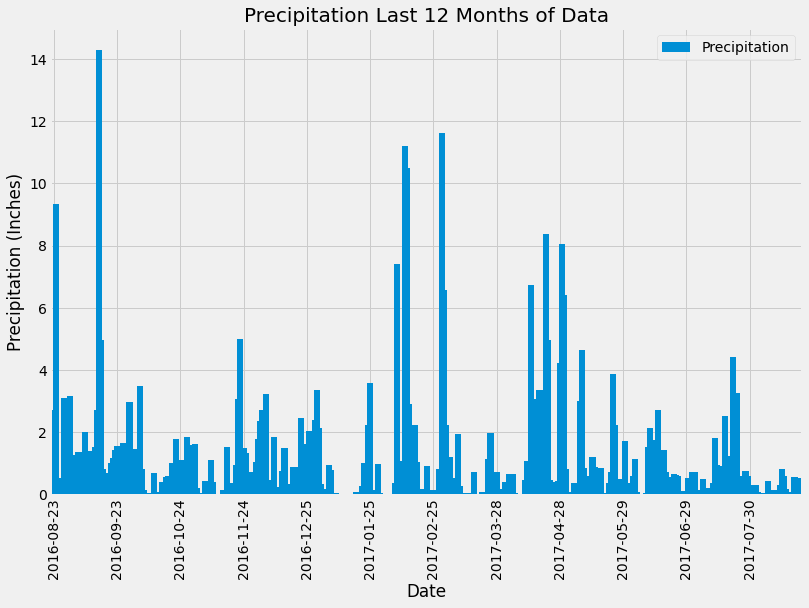

In [108]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=12)
ax.tick_params(axis='y')
ax.grid(True)
plt.title("Precipitation Last 12 Months of Data", size=20)
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")
plt.show

In [109]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [111]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [146]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_id = active_stations[0][0]
temp_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),\
    func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all()

min_temp = [temp[0] for temp in temp_stats]
max_temp = [temp[1] for temp in temp_stats]
average_temp = [temp[2] for temp in temp_stats]

print(f'Minimum temperature:{min_temp}\nMaximum temp: {max_temp}\nAverage temp: {average_temp}')


Minimum temperature:[54.0]
Maximum temp: [85.0]
Average temp: [71.66378066378067]


Text(0.5, 1.0, '12mo Temp Observations for USC00519281')

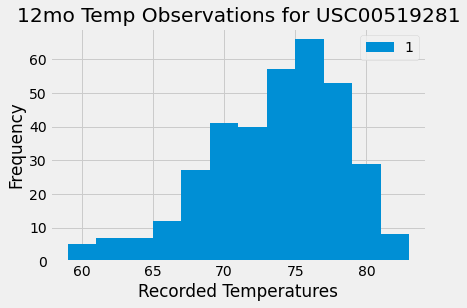

In [155]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_12mo = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
        filter(Measurement.date >= start_date).all()

top_station_12mo_df = pd.DataFrame(top_station_12mo)
top_station_12mo_df.plot.hist(by='station',bins=12,)
plt.xlabel('Recorded Temperatures')
plt.title(f"12mo Temp Observations for {most_active_station_id}")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
